# Результаты тестирования на IAM

In [1]:
import albumentations as A
import copy
import cv2
import Levenshtein
import matplotlib.pyplot as plt
import os
import pandas as pd
import pathlib
import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Посмотрим на некотрые изображения из обучающего датасета:

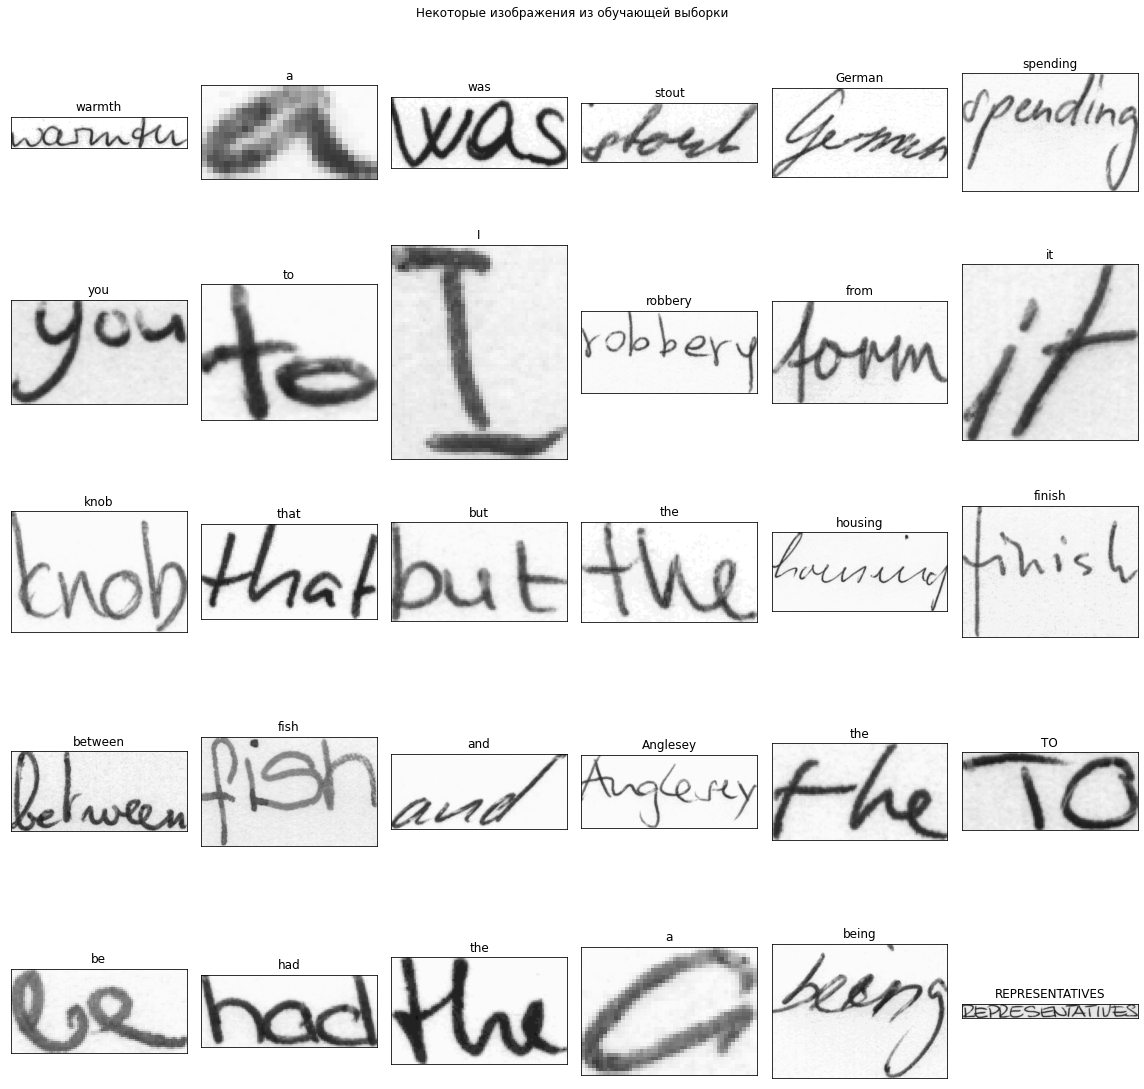

In [2]:
train_dir = '/home/astrashnov/data/rec/iam_data/train_words'
imgs = os.listdir(train_dir)
imgs = random.choices(imgs, k=30)

plt.figure(figsize=(16, 16))
for i, img in enumerate(imgs):
    label = img.split('_')[0]
    image = cv2.imread(os.path.join(train_dir, img))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Некоторые изображения из обучающей выборки')
plt.tight_layout()
plt.show()

Получим предсказания обученной модели, а также правильные метки:

In [3]:
pred_file = '/home/astrashnov/PaddleOCR/output/rec/predicts_srn_original_LC_UC_Num_Pc3.txt'
target_file = '/home/astrashnov/data/rec/iam_data/rec_test.txt'

In [4]:
def get_dict(filename):
    with open(filename) as f:
        lines = f.readlines()
    word_dict = {}
    for line in lines:
        l = line.strip('\n')
        if len(l) == 0:
            continue
        img_path, label = l.split('\t')[:2]
        word_dict[pathlib.PurePath(img_path).name] = label
    return word_dict

In [5]:
def general_stat(predictions_file, target_file, long_word_min_len=10):
    pred_dict = get_dict(predictions_file)
    target_dict = get_dict(target_file)

    cases = ('LC + UC, all words', 'LC + UC, long words', 'MC, all words', 'MC, long words')
    correct_num = {case: 0 for case in cases}
    edit_dis = {case: 0.0 for case in cases}
    norm_edit_dis = {case: 0.0 for case in cases}
    long_num = 0
    all_num = 0
    long_char = 0
    all_char = 0

    for name, target in target_dict.items():
        pred = pred_dict[name]
        pred_target = {'LC + UC': (pred, target), 'MC': (pred.lower(), target.lower())}

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            cur_edit_dis = Levenshtein.distance(pred, target)
            is_correct = int(pred == target)

            correct_num[case + ', all words'] += is_correct
            edit_dis[case + ', all words'] += cur_edit_dis
            norm_edit_dis[case + ', all words'] += cur_edit_dis / len(target)

            if is_long:
                correct_num[case + ', long words'] += is_correct
                edit_dis[case + ', long words'] += cur_edit_dis
                norm_edit_dis[case + ', long words'] += cur_edit_dis / len(target)

        all_char += len(target)
        all_num += 1

        if is_long:
            long_char += len(target)
            long_num += 1

    acc = {'Accuracy ({})'.format(case): 1.0 * correct_num / max(all_num if (case[-9:-6] == 'all') else long_num, 1)
            for case, correct_num in correct_num.items()}
    norm_edit_dis = {'Normalized edit distance 1 ({})'.format(case): dis / max(all_num if (case[-9:-6] == 'all') else long_num, 1)
            for case, dis in norm_edit_dis.items()}
    edit_dis = {'Normalized edit distance 2 ({})'.format(case): dis / max(all_char if (case[-9:-6] == 'all') else long_char, 1)
            for case, dis in edit_dis.items()}
    quality_dict = dict(**acc, **norm_edit_dis, **edit_dis)

    for key, value in quality_dict.items():
        print(f'{key}: {value}')

In [6]:
def detailed_stat(predictions_file, target_file, long_word_min_len=10):
    pred_dict = get_dict(predictions_file)
    target_dict = get_dict(target_file)

    alphabet = "'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
    cases = ('LC + UC, all words', 'LC + UC, long words', 'MC, all words', 'MC, long words')
    matrix1 = {'del': {char: 0 for char in alphabet}, 'ins': {char: 0 for char in alphabet}}
    matrix1 = dict(**matrix1, **{sym: {char: 0 for char in alphabet} for sym in alphabet})
    matrix2 = {'del': {char: 0 for char in alphabet[:-26]}, 'ins': {char: 0 for char in alphabet[:-26]}}
    matrix2 = dict(**matrix2, **{sym: {char: 0 for char in alphabet[:-26]} for sym in alphabet[:-26]})
    matrices = {case: copy.deepcopy(matrix1) if case[0] == 'L' else copy.deepcopy(matrix2) for case in cases}
    
    mistakes = []
    for name, target in target_dict.items():
        pred = pred_dict[name]
        pred_target = {'LC + UC': (pred, target), 'MC': (pred.lower(), target.lower())}
        
        if target != pred:
            mistakes.append((pred, target, name))

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            ops = Levenshtein.editops(pred, target)
            matrices_names = [case + ', all words',]
            if is_long:
                matrices_names.append(case + ', long words')
            for matrix_name in matrices_names:
                for op in ops:
                    if op[0] == 'insert':
                        matrices[matrix_name]['ins'][target[op[2]]] += 1
                    elif op[0] == 'delete':
                        matrices[matrix_name]['del'][pred[op[1]]] += 1
                    elif op[0] == 'replace':
                        matrices[matrix_name][pred[op[1]]][target[op[2]]] += 1
                        
    tables = {}
    for case in cases:
        tables[case] = pd.DataFrame.from_dict(matrices[case]).transpose()
        
    return tables, mistakes

##### Качество модели:

In [7]:
general_stat(pred_file, target_file)

Accuracy (LC + UC, all words): 0.8204449450858913
Accuracy (LC + UC, long words): 0.5769230769230769
Accuracy (MC, all words): 0.8344691636158829
Accuracy (MC, long words): 0.5854700854700855
Normalized edit distance 1 (LC + UC, all words): 0.06230641287524718
Normalized edit distance 1 (LC + UC, long words): 0.08412862835890159
Normalized edit distance 1 (MC, all words): 0.05652085561827345
Normalized edit distance 1 (MC, long words): 0.08240403528815465
Normalized edit distance 2 (LC + UC, all words): 0.06986481033091202
Normalized edit distance 2 (LC + UC, long words): 0.08645982084901986
Normalized edit distance 2 (MC, all words): 0.06495914043583535
Normalized edit distance 2 (MC, long words): 0.08464234713747891


In [8]:
tables, mistakes = detailed_stat(pred_file, target_file)

Посмотрим на посимвольные таблицы ошибок для разных длин слов с учётом и без учёта регистра:

In [9]:
tables['LC + UC, all words']

,',-,.,0,1,2,3,4,5,6,7,8,9,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
del,0,1,5,0,0,0,0,0,0,0,0,0,0,35,4,37,14,60,17,10,20,32,1,2,25,5,33,28,6,1,46,24,40,23,10,4,1,5,0,3,1,2,1,0,0,0,0,2,0,0,0,1,0,1,1,0,0,2,1,0,0,0,0,0,0
ins,7,5,4,1,3,0,0,0,1,0,0,0,0,21,1,26,10,78,10,18,22,27,1,5,57,7,42,36,5,0,94,91,69,21,8,9,1,12,1,4,1,0,0,1,0,0,0,5,0,1,0,0,0,1,3,0,0,2,3,0,0,0,0,0,0
',0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
.,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [10]:
tables['MC, all words']

,',-,.,0,1,2,3,4,5,6,7,8,9,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
del,0,1,5,0,0,0,0,0,0,0,0,0,0,37,5,39,15,62,18,10,20,34,1,2,25,5,34,29,7,1,47,25,42,23,10,4,1,5,0
ins,7,5,4,1,3,0,0,0,1,0,0,0,0,22,2,26,10,80,10,17,21,33,1,6,60,7,42,36,7,0,96,93,73,22,8,10,1,12,1
',0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0
.,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0


In [11]:
tables['LC + UC, long words']

,',-,.,0,1,2,3,4,5,6,7,8,9,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
del,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,4,3,1,1,1,2,2,0,0,3,0,3,2,0,0,2,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ins,2,2,0,0,0,0,0,0,0,0,0,0,0,6,1,5,2,13,0,1,5,6,0,1,17,2,18,4,2,0,17,20,7,3,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
',0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
tables['MC, long words']

,',-,.,0,1,2,3,4,5,6,7,8,9,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
del,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,4,3,1,1,1,2,2,0,0,3,0,3,2,0,0,2,4,2,2,0,0,0,0,0
ins,2,2,0,0,0,0,0,0,0,0,0,0,0,6,1,5,2,13,0,1,5,6,0,1,18,2,17,4,2,0,17,20,7,3,0,2,0,1,1
',0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Посмотрим на некоторые неправильно распознанные изображения:

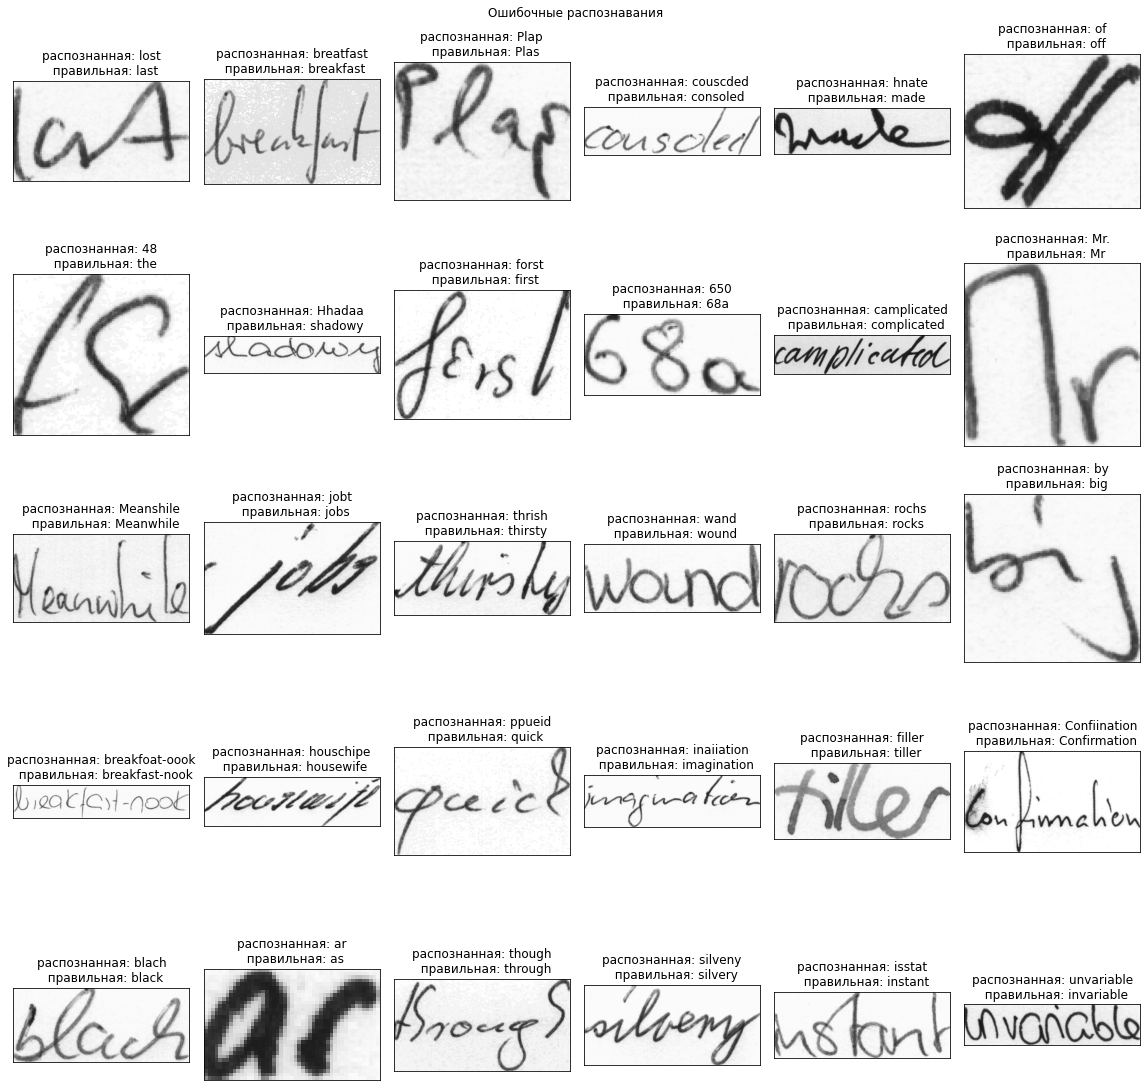

In [13]:
test_dir = '/home/astrashnov/data/rec/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

Видно, что большая часть ошибок - пропущенные или лишние символы в слове. Объяснение этому даётся в статье про SRN: если на этапе нахождения визуального контекста модель неправильно определила количество символов, она уже не может исправить это на этапе учёта семантического контекста.